<a href="https://colab.research.google.com/github/andylynchul/ET5003_Assignments/blob/master/Week%203/ET5003_Etivity2_ALynch_20208189.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [365]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [366]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20208189" #@param {type:"string"}
Student_full_name = "Andrew Lynch" #@param {type:"string"}
#@markdown ---

In [367]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# INTRODUCTION

The problem presented here was to predict house prices given a set of parameters such as location, size, bedrooms, bathrooms etc. The decided approach was to apply exploratory data analysis, regression analysis to see if an accurate model could be derived. On initial analysis of the data, it was noted that geolocation data, in the form of longitude/latitude, was included in the data set. So, this is where some intuition should be applied by the analyst. It stands to reason that house prices are dictated by location, so it also stands to reason that there may be some value in grouping the data into clusters leading to more accurate model prediction within the cluster rather than the overall data set. Piecewise Regression was identified as a potentially good fit for the solution. To validate this an analysis of the data in terms of clustering will be applied. To achieve this some EDA will be applied to the data to clean and select the most relevant features. A baseline regression model will be derived with a similar analysis being applied to the clusters and a comparison will be made using mean average error to see if a better result can be attained. There are a number of features of the solution that could be tuned such as the method or clustering, the number of clustering, the feature reduction, feature selection etc.

## Imports

In [368]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [369]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [370]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [371]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# Functions

# DATASET

##Loading Data

In [372]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Masters/Year2/ET5003/Week3/Data/'

# House Data
train_data = Path + 'house_train.csv'
test_data = Path + 'house_test.csv'
cost_data = Path + 'true_price.csv'

# train data
df_train = pd.read_csv(train_data)

# test data
df_test = pd.read_csv(test_data)

# test data
df_cost = pd.read_csv(cost_data)

# test data
#df_test = df_test.join(df_cost.drop("Id", axis=1))


print(df_train.shape)
print(df_test.shape)
print(df_cost.shape)

Mounted at /content/drive
(2982, 17)
(500, 16)
(500, 2)


On initial assessment of the data it contains training data (2982 records with 17 features including price), test data (500 records with 16 features not including price) and test house prices (500 records that align to the test data set through the id feature to ad_id). Initial thoughts are we already have a train / test split so no need to split the data. Next step is to apply EDA to get a good read on the data.

# Exploritory Data Analysis

## High Level Analysis

In [373]:
df_train.tail()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,Property Team Patrick Moran is delighted to pr...,prod,NaN,Totally refurbished to the highest standard. \...,53.335793,-6.294268,NaN,485000.0,sale,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,Dublin,Earnest estate agents are delighted to present...,prod,Wired for Cable Television,OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...,53.346098,-6.276856,NaN,299000.0,sale,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,Dublin,Janet Carroll Estate Agents are pleased to pre...,prod,"Parking,Gas Fired Central Heating",None,53.273518,-6.178500,NaN,495000.0,sale,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,D2,Dublin,ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...,prod,NaN,Charming three-bedroom family home\nMinutes aw...,53.310073,-6.325158,NaN,525000.0,sale,semi-detached,129.3


In [374]:
df_test.tail()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
495,12369815,Ringsend,1.0,2.0,NaN,Dublin,***SUPERB LOCATION / PRIVATE PARKING OPTION AV...,prod,NaN,Adjacent to Grand Canal Dock\nClose to a host ...,53.342207,-6.226101,NaN,sale,apartment,65.0
496,12416011,Cabinteely,3.0,5.0,E1,Dublin,"OPEN VIEWING SATURDAY 7TH MARCH, 10.00AM - 10....",prod,"Parking,Alarm,Oil Fired Central Heating",Excellently presented 5 bedroom family home\nE...,53.261475,-6.147720,NaN,sale,detached,191.3
497,12232222,Artane,1.0,3.0,G,Dublin,Sherry FitzGerald is delighted to present to t...,prod,NaN,Detached Family Home\nOnly One Owner\nMature C...,53.391619,-6.205157,NaN,sale,detached,105.0
498,11905630,Clontarf,2.0,4.0,E2,Dublin,Modernised yet still in touch with it's period...,prod,"Parking,Gas Fired Central Heating,Alarm,Wired ...",Stunning coastal views.\nExcellent condition t...,53.360578,-6.183701,NaN,sale,end-of-terrace,130.0
499,12394865,Drumcondra,2.0,2.0,C1,Dublin,MOVEHOME ESTATE AGENTS .. are delighted to pre...,prod,NaN,* Spacious two Bedroom master ensuite apartmen...,53.366827,-6.248329,NaN,sale,apartment,71.0


In [375]:
df_cost.tail()

,Id,Expected
495,12369815,345000.0
496,12416011,775000.0
497,12232222,360000.0
498,11905630,925000.0
499,12394865,325000.0


On initial review features and description_block and features look like candidates for removal due the fact they would be difficult to encode and may lead to low value features.


In [376]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               2982 non-null   int64  
 1   area                2982 non-null   object 
 2   bathrooms           2931 non-null   float64
 3   beds                2931 non-null   float64
 4   ber_classification  2305 non-null   object 
 5   county              2982 non-null   object 
 6   description_block   2982 non-null   object 
 7   environment         2982 non-null   object 
 8   facility            965 non-null    object 
 9   features            2982 non-null   object 
 10  latitude            2982 non-null   float64
 11  longitude           2982 non-null   float64
 12  no_of_units         59 non-null     float64
 13  price               2892 non-null   float64
 14  property_category   2982 non-null   object 
 15  property_type       2931 non-null   object 
 16  surfac

In [377]:
df_train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


In [378]:
# Use this to get some high level information about the missing data
df_train.isna().sum()

ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

In [379]:
# Find the number of nulls/NaNs in the dataset as a percentage to see if any columns need to be considered for removal
print("Read of missing values as percentage of data set")
df_train.isna().sum()*100/len(df_train)

Read of missing values as percentage of data set


ad_id                  0.000000
area                   0.000000
bathrooms              1.710262
beds                   1.710262
ber_classification    22.702884
county                 0.000000
description_block      0.000000
environment            0.000000
facility              67.639168
features               0.000000
latitude               0.000000
longitude              0.000000
no_of_units           98.021462
price                  3.018109
property_category      0.000000
property_type          1.710262
surface               18.477532
dtype: float64

From analysis of missing values no_of_units and facilities look likely to be dropped as they are outside the 25% threshold (i.e. features missing more than 25% can be discarded.)

## High Level Correleation Analysis

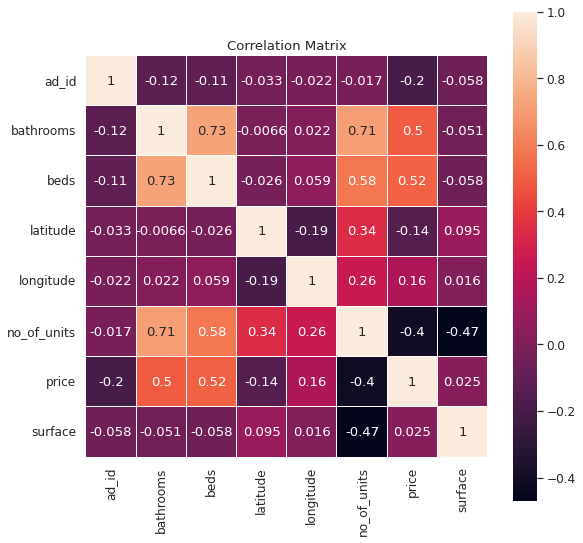

In [380]:
# calculate the correlation matrix
corr = df_train.corr()

# plot the heatmap
sns.set(font_scale=1.10)
plt.figure(figsize=(9, 9))
plt.title('Correlation Matrix')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,linewidths=0.01,square=True,annot=True)

Correlation Matrix shows a positive correlation between Price, Bedreooms (0.52) and Bathrooms (0.5) pointing towards these as to potential selections as important features.

Pairplots of numerical features


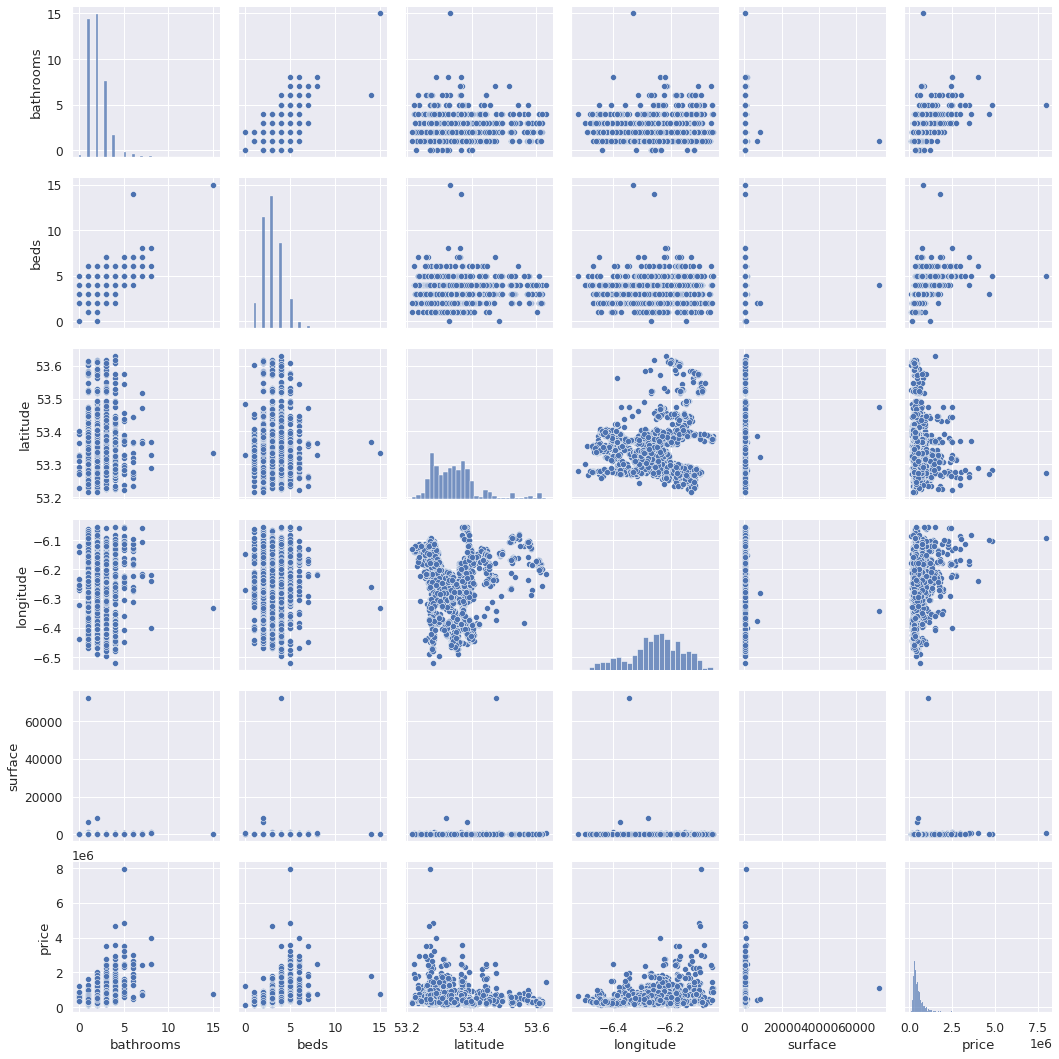

In [381]:

# Pairplot to see the relationship between numerical features. The method dropna() drops all rows with missing values 
# No of units and facility are removed due to high number of NULL values
print('Pairplots of numerical features')
sns.pairplot(data=df_train[['bathrooms','beds','ber_classification','latitude','longitude','surface','price']].dropna())
plt.show()

By analysing the Pairwise plots it can be seen that some of the features are suffering from outlier effects. Bathrooms, Beds, Surface, Longitude, Latitude - this can be seen by visually assessing the plots and looking for the data being skewed to one area of the plot.

##Categorical Data Analysis

In [382]:
# Get a read of Categorical Values
cat_cols = df_train.select_dtypes(include=['object'])     #strip out the categorical cols
cat_cols.columns[cat_cols.any()].tolist()           #convert col names to list
for i in cat_cols:                                  #loop through the cols
    print(cat_cols[i].value_counts(),"\n")          #print the summary to analyse

Finglas          94
Castleknock      90
Rathfarnham      87
Malahide         81
Lucan            79
                 ..
Bayside           1
Ard Na Greine     1
Kiltipper         1
Coolmine          1
Ballymount        1
Name: area, Length: 156, dtype: int64 

D1                     283
D2                     274
C3                     268
C2                     242
C1                     212
E1                     182
E2                     169
G                      166
F                      165
B3                     130
B2                      74
A3                      70
SINo666of2006exempt     28
A2                      25
B1                      16
A1                       1
Name: ber_classification, dtype: int64 

Dublin    2982
Name: county, dtype: int64 

LEONARD WILSON KEENAN ESTATE &amp; LETTING AGENTS \r\nOur business is you ....\n\r\nEXTRA SPACIOUS EXTENDED 3 BED / 1 BATH SEMI DETACHED BUNGALOW ON LARGE SITE \r\nSOUTH WEST FACING BACK GARDEN \r\nEXCELLENT FURTHER POTENTI

Based on the analysis to date I dropped certain features. Namely


*   ['ad_id','area','property_category','description_block', 'features','no_of_units','facility', 'environment', 'county']




In [383]:
drop_features = ['ad_id','area','property_category','description_block', 'features','no_of_units','facility', 'environment', 'county']

df_train_eda = df_train.drop(drop_features, axis=1)

# Get a read of remaining Categorical Values
cat_cols = df_train_eda.select_dtypes(include=['object'])     #strip out the categorical cols
cat_cols.columns[cat_cols.any()].tolist()           #convert col names to list
for i in cat_cols:                                  #loop through the cols
    print(cat_cols[i].value_counts(),"\n")          #print the summary to analyse

D1                     283
D2                     274
C3                     268
C2                     242
C1                     212
E1                     182
E2                     169
G                      166
F                      165
B3                     130
B2                      74
A3                      70
SINo666of2006exempt     28
A2                      25
B1                      16
A1                       1
Name: ber_classification, dtype: int64 

apartment         759
semi-detached     754
terraced          554
detached          398
end-of-terrace    237
bungalow           84
duplex             60
site               55
townhouse          27
studio              3
Name: property_type, dtype: int64 



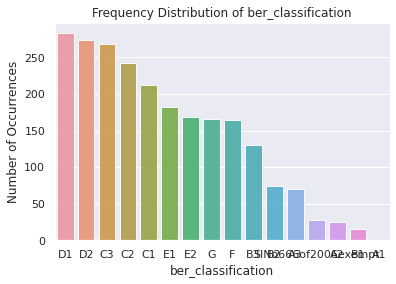

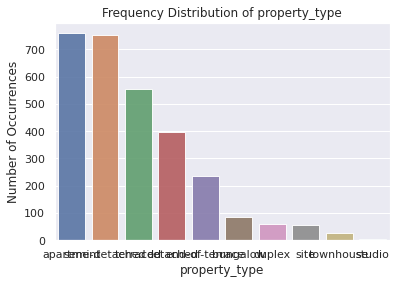

In [384]:
# Get a read of Categorical Values Visualy (Frequency Distribution Plots)
for i in cat_cols:                                  #loop through the cols
    plot_count = cat_cols[i].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(plot_count.index, plot_count.values, alpha=0.9)
    plt.title('Frequency Distribution of '+cat_cols[i].name)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(cat_cols[i].name, fontsize=12)
    plt.show()

## Analysis of BER Rating
BER is identified as a feature that will add value to the model and is missing 622 (22%) values so some further analysis of this data is warranted. It is just within the 25% threshold for removal and is well distributed across the data set

Text(0.5, 1.0, 'Count of BER for 2nd hand properties')

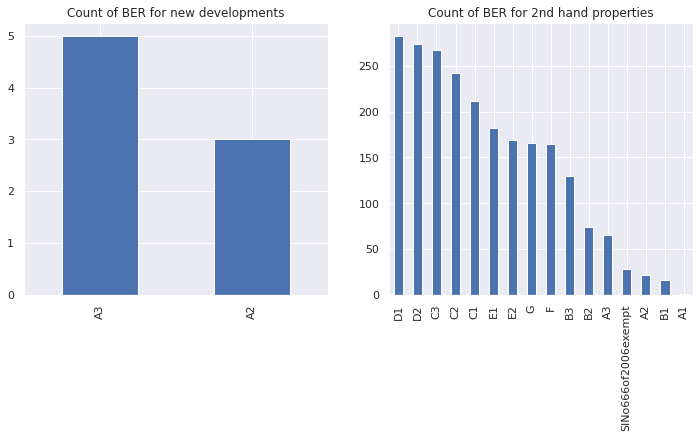

In [385]:
# Courtesy of Carlos during our forum discussons
# Plot couting of BER rating by property category 

ber_new=df_train[df_train['property_category']=='new_development_parent']
ber_used=df_train[df_train['property_category']=='sale']

plt.subplots(2,2,figsize=(12,5))
plt.subplot(1, 2, 1) 
ber_new['ber_classification'].value_counts().plot(kind='bar')
plt.title('Count of BER for new developments')
plt.subplot(1, 2, 2) 
ber_used['ber_classification'].value_counts().plot(kind='bar')
plt.title('Count of BER for 2nd hand properties')

BER rating is missing for 22% of the records. A breakdown of BER by property category - new development or sale (2nd hand) - shows that all new developments are either rating A2 or A3. On the other hand, very few 2nd hand properties are rating A. Inputting the average BER rating to 2nd hand propertied where missing taking the property category into account as all new developments are rating A. Property_category is not deemed useful for the modelling but useful to impute the missing BER data.

## Numerical Data Analysis

In [386]:
#Calculate missing values for the numerical features.
print(df_train.select_dtypes(exclude=['object']).isna().sum())

ad_id             0
bathrooms        51
beds             51
latitude          0
longitude         0
no_of_units    2923
price            90
surface         551
dtype: int64


## EDA Summary
1. On initial examination of the data it was clear **description_block** and **features** were not in any format to systematically encode so it was decided early that these features could be discarded.
2. On analysis of the missing values it was seen that **no_of_units** and **facilities** had more than 25% of their values missing which meant these features could be removed from further analysis
3. Both **environment** and **county** both are single values throughout offering no value so can be disregarded from further analysis
4. **ad_id** is just the data index and offers no value so can be disregarded from further analysis
5. **Area** is an interesting one as it has 156 unique entries and clearly could offer some value in the prediction of price. In the context of this problem, it was felt that one-hot encoding the data would lead to too many features running the risk of producing low signal regressors [Johannemann et al. 2020].
6. **property_category** was another interesting one. It was examined and felt the data was heavily skewed towards the sale (accounting for 98% of the data set) so this would not be used in building the model. The data was used to impute the missing BER values for 2nd hand houses (Carlos)
7.  **BER_classificaton** and **property_type** the selected to be the retained categorical data as they were distributed across the data set and could be ordinaly & one hot encoded without increasing the number of features too much.
 




#Data Preparation

## Feature Selection

Here I just dropped the features identified from the EDA from both the training and test set so the data sets are aligned.

In [387]:
drop_features = ['ad_id','area','property_category','description_block', 'features','no_of_units','facility', 'environment', 'county']

df_train_p = df_train.drop(drop_features, axis=1)
df_test_p = df_test.drop(drop_features, axis=1)

## Encoding of Categorical Data

### BER Rating (Ordinal Encoding)
Seen as the BER rating does have oridinal characteristics (i.e A1 is more valuable to the model than G) I decided to ordinally encode the BER _classification from 0 to 15 as per below

In [388]:
#Convert BER classification into ordinal features
# Map BER categories 
if 'ber_classification' in df_train_p:
  BERMap = {
      "A1": 1,
      "A2": 2,
      "A3": 3,
      "B1": 4,
      "B2": 5,
      "B3": 6,
      "C1": 7,
      "C2": 8,
      "C3": 9,
      "D1": 10,
      "D2": 11,
      "E1": 12,
      "E2": 13,
      "F": 14,
      "G": 15,
      "SINo666of2006exempt" : 0
  }
  df_train_p['ber_classification'] = df_train_p['ber_classification'].replace(BERMap)
  df_test_p['ber_classification'] = df_test_p['ber_classification'].replace(BERMap)

Once encoded we used the property_category to find the mean classification and apply that to the missing values.

In [389]:
# Replace 'N/A' values in ber_classification with mean of the same property category
if 'ber_classification' in df_train_p:
  ber_avg_set = df_train_p[df_train['property_category']=='sale']
  ber_avg_val = round(ber_avg_set['ber_classification'].mean(),0) # mean of ber classification rounded to the nearest whole number. 

  df_train_p['ber_classification'].fillna(ber_avg_val, inplace=True) # Only 2nd hand properties are missing BER. Therefore, we input the average for 2nd hand ones

  print("BER classification replacing missing values for 2nd hand properties: ",ber_avg_val)

BER classification replacing missing values for 2nd hand properties:  10.0


### Property Category  (One Hot Encoding)

There was some discussion around the fact the property_type could be ordinaly encoded but I couldn't see the justification. The property_type doesn't necessarily offer more value as a terraced house in one area could be more valuable than in another so I think this data is more suited to a one hot encoding which will let the model decide on the importance of the property_types in each of the areas.

In [390]:
#one hot encode all the remaining categorical fields

if 'property_type' in df_train_p:
  # creating instance of one-hot-encoder
  enc = OneHotEncoder(handle_unknown='ignore')

  #enc_df_train = pd.DataFrame(enc.fit_transform(df_train_p[['property_type']]).toarray())
  #df_train_p = df_train_p.join(enc_df_train)

  #enc_df_test  = pd.DataFrame(enc.fit_transform(df_test_p[['property_type']]).toarray())
  #df_test_p = df_test_p.join(enc_df_test)

  # now one-hot encode all categorical columns with nan
  df_train_p = pd.get_dummies(df_train_p, columns=['property_type'], 
                          dummy_na=True, 
                          drop_first=True)

  # now one-hot encode all categorical columns with nan
  df_test_p = pd.get_dummies(df_test_p, columns=['property_type'], 
                          dummy_na=True, 
                          drop_first=True)
  df_train_p.tail()

## Dealing with Missing Values

Based on the Numeric EDA I saw the features with missing values. It was decided the bedrooms / bathrooms were low so were dropped. Surface was missing 551 so just dropping data based on that feature would have resulted in ~25% loss so we inputted the mean value in to fill the missing values.

In [391]:
# First filter out those rows that
# do not contain any data
df_train_p.dropna(subset=['price'], axis=0, inplace=True) 

df_train_p.drop(df_train_p[df_train_p['beds'] == 0].index, inplace = True)
df_test_p.drop(df_test_p[df_test_p['beds'] == 0].index, inplace = True)

df_train_p.drop(df_train_p[df_train_p['bathrooms'] == 0].index, inplace = True)
df_test_p.drop(df_test_p[df_test_p['bathrooms'] == 0].index, inplace = True)

df_train_p['surface'].fillna(df_train_p['surface'].mean(), inplace=True)
df_test_p['surface'].fillna(df_test_p['surface'].mean(), inplace=True)

print(df_train_p.select_dtypes(exclude=['object']).isna().sum())

bathrooms                       0
beds                            0
ber_classification              0
latitude                        0
longitude                       0
price                           0
surface                         0
property_type_bungalow          0
property_type_detached          0
property_type_duplex            0
property_type_end-of-terrace    0
property_type_semi-detached     0
property_type_site              0
property_type_studio            0
property_type_terraced          0
property_type_townhouse         0
property_type_nan               0
dtype: int64


## Detection & Removal of Outliers

In [392]:
# Function to Detection Outlier on one-dimentional datasets.
def remove_outliers(dframe, feature):
    '''Function to Detect / Remove Outliers'''
  
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(dframe[feature])
    random_data_mean = np.mean(dframe[feature])
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    
    dframe = dframe.drop(dframe[(dframe[feature] < lower_limit) | (dframe[feature] > upper_limit)].index)

    return dframe

def plot_box_hist(dframe, features):
    '''Function to plot Box / Histogram pair for any feature'''
    no_feats = len(features)
  
    figH = plt.figure(figsize=(30,no_feats*5))

    for i in range(0, no_feats): 
        ax1 = figH.add_subplot(no_feats, 2, (i*2)+1)
        ax1.set_title("Boxplot of "+features[i])
        dframe.boxplot(column=[features[i]])

        ax2 = figH.add_subplot(no_feats, 2, (i*2)+2)
        ax2.set_title("Histogram of "+features[i])
        dframe[features[i]].hist(bins=20)

    plt.show()


It was decided that the ['beds','bathrooms','surface'] could be subjected to z-score removal (i.e. analyse the data and remove any items that are more than 3 times the standard deviation). This seemed to give a much better distribution of data looking at the before and after plots below. 

Analysis of outliers


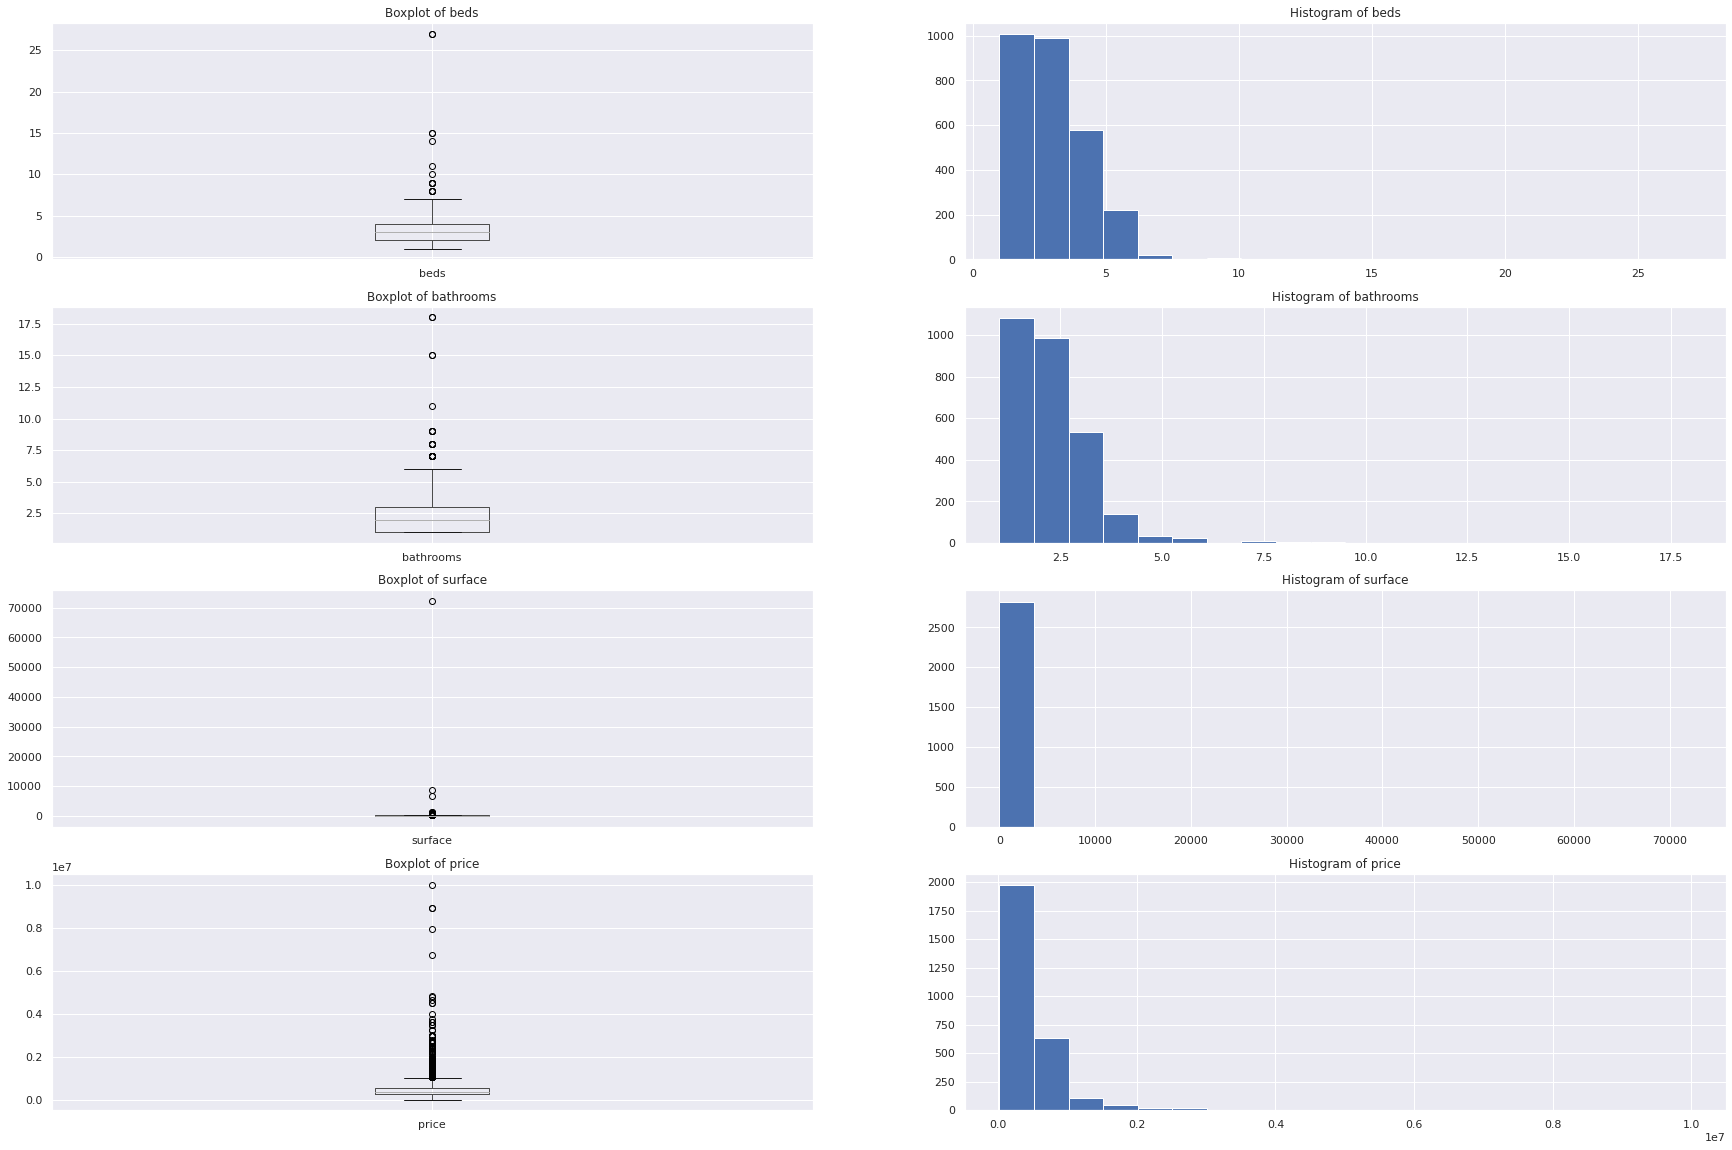

(2828, 17)
After outliers have been removed


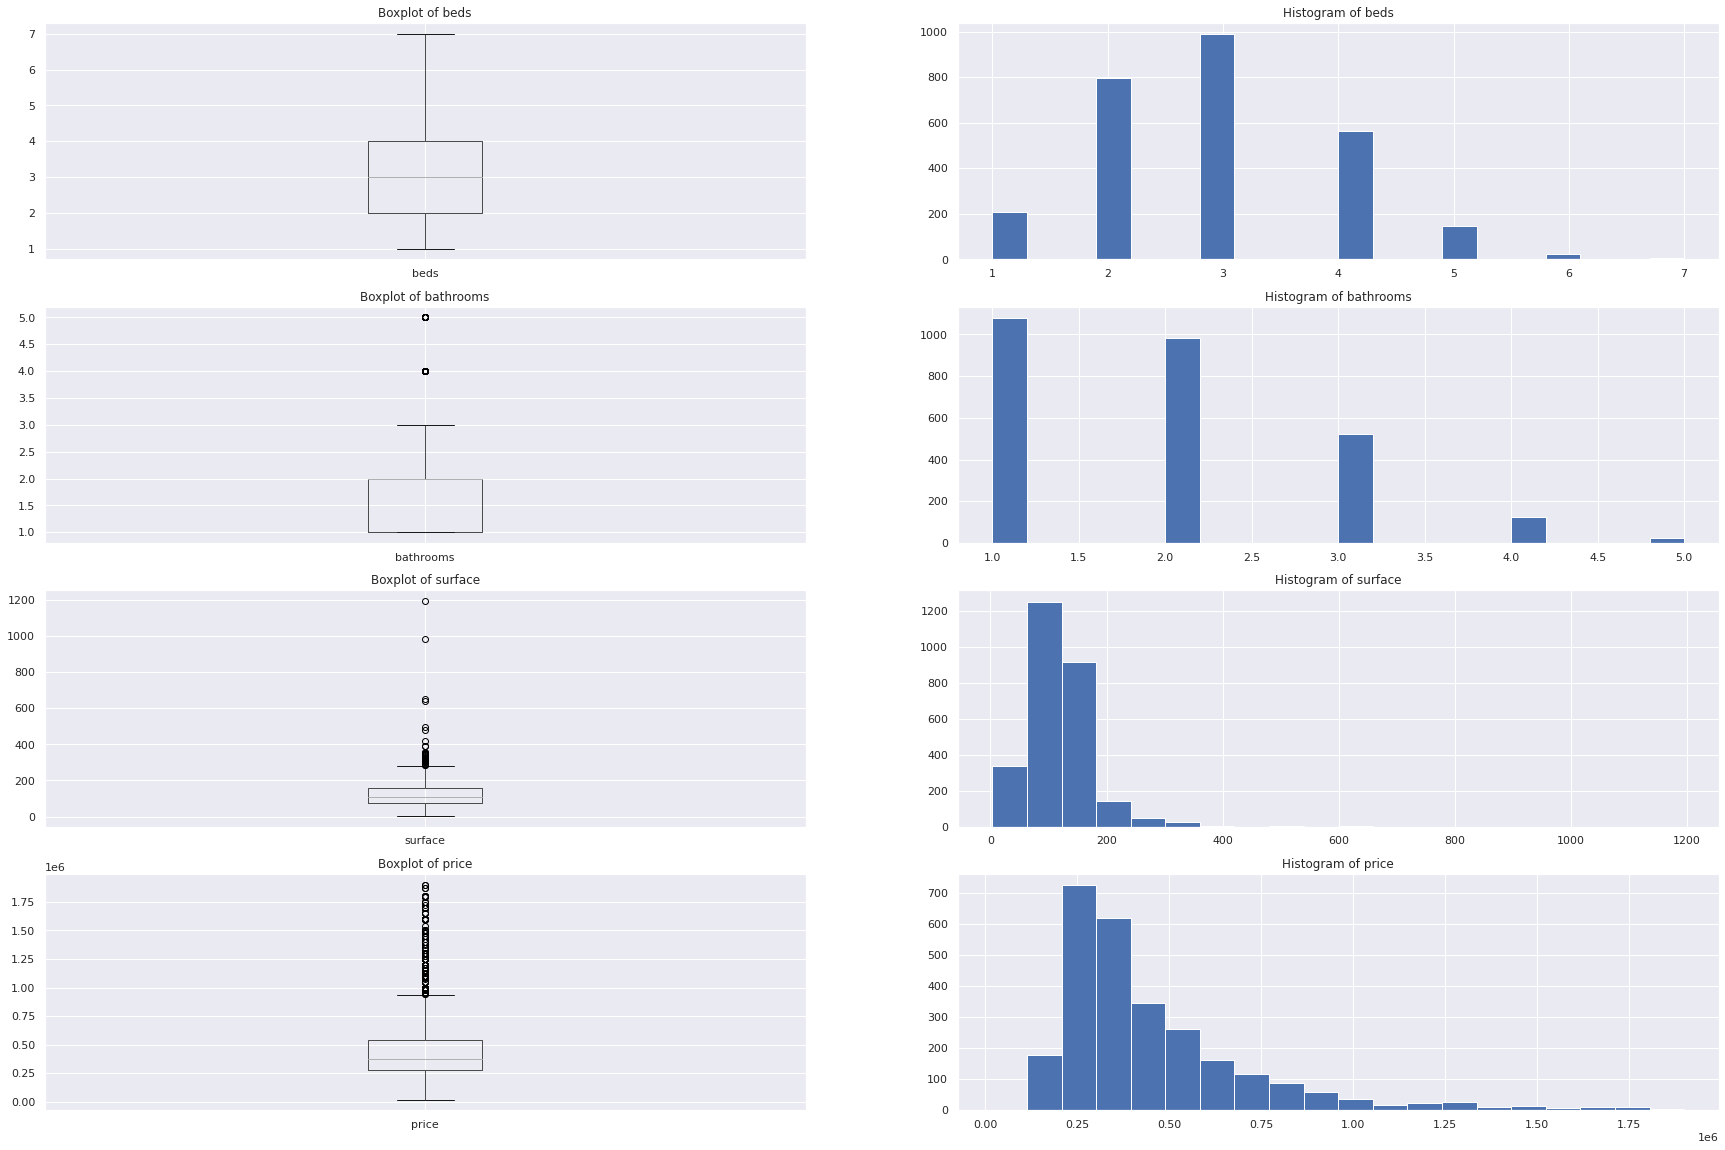

(2729, 17)


In [393]:
#Select features to include in plots
include_featues = ['beds','bathrooms','surface', 'price']

#run print function
print("Analysis of outliers")
plot_box_hist(df_train_p, include_featues)
print(df_train_p.shape)

print("After outliers have been removed")
for i in range(0, len(include_featues)): 
    df_train_p = remove_outliers(df_train_p,include_featues[i])
    if (include_featues[i] != 'price'):
      df_test_p = remove_outliers(df_test_p,include_featues[i])

#run print function
plot_box_hist(df_train_p, include_featues)
print(df_train_p.shape)

## Longitude / Latitude Outliers
Initially I had included the long/lat features in my z-score routing to strip outliers but Carlos and Mark both pointed out that this could have resulted in some data points on the outskirts of the geo being stripped. On analysis of the plots - there only seems to be two values that can be manually removed. I identified the long / lat limits they existed beyond and selected the data from the DataFrame accordingly. 

In [394]:
index_train = df_train_p[(df_train_p['longitude'] > -6.0)|(df_train_p['latitude'] < 53.0)].index
index_test = df_test_p[(df_test_p['longitude'] > -6.0)|(df_test_p['latitude'] < 53.0)].index
df_train_p.drop(index_train, inplace=True)
df_test_p.drop(index_test, inplace=True)

print(df_train_p.shape)
print(df_test_p.shape)

(2727, 17)
(474, 16)


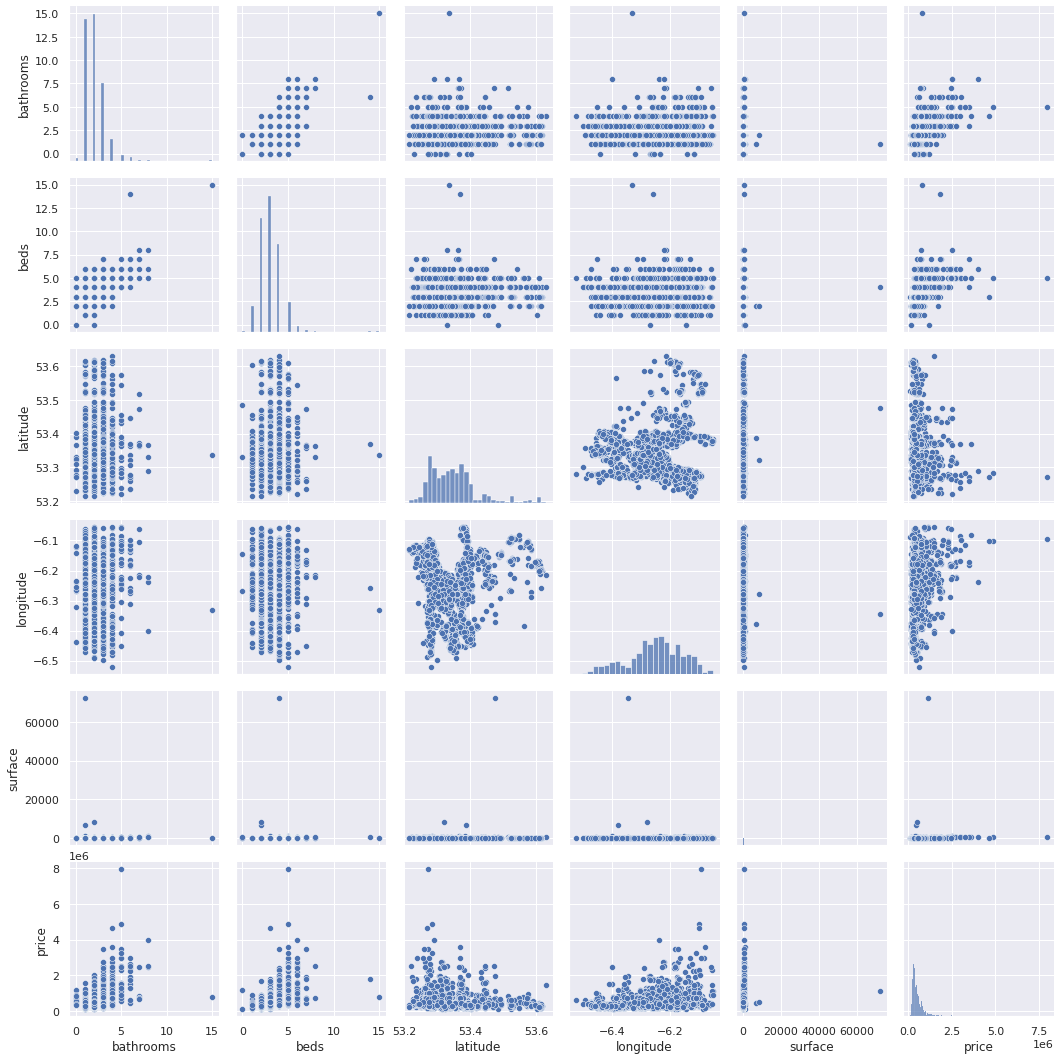

In [395]:
sns.pairplot(data=df_train[['bathrooms','beds','ber_classification','latitude','longitude','surface','price']].dropna())
plt.show()

## Training & Test Data

### Train dataset

In [396]:
# show first data frame rows 
df_train_p.tail()

,bathrooms,beds,ber_classification,latitude,longitude,price,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,property_type_nan
2977,2.0,2.0,9.0,53.338738,-6.237199,415000.0,56.0,0,0,0,0,0,0,0,0,0,0
2978,1.0,3.0,5.0,53.335793,-6.294268,485000.0,101.0,0,0,0,0,0,0,0,1,0,0
2979,1.0,2.0,9.0,53.346098,-6.276856,299000.0,55.6,0,0,0,0,0,0,0,0,0,0
2980,2.0,3.0,9.0,53.273518,-6.178500,495000.0,97.0,0,0,0,1,0,0,0,0,0,0
2981,2.0,3.0,11.0,53.310073,-6.325158,525000.0,129.3,0,0,0,0,1,0,0,0,0,0


In [397]:
# show first data frame rows 
df_train_p.describe()

,bathrooms,beds,ber_classification,latitude,longitude,price,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,property_type_nan
count,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2.727000e+03,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.0
mean,1.911624,2.900990,9.789879,53.357222,-6.263092,4.605826e+05,118.658289,0.027869,0.118078,0.022002,0.083975,0.266227,0.000733,0.001100,0.195086,0.009901,0.0
std,0.913280,1.054158,2.884332,0.076953,0.091584,2.792426e+05,61.457709,0.164629,0.322760,0.146717,0.277401,0.442065,0.027077,0.033156,0.396340,0.099028,0.0
min,1.000000,1.000000,0.000000,53.215264,-6.521183,1.999500e+04,3.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,2.000000,8.000000,53.300240,-6.316727,2.790000e+05,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,3.000000,10.000000,53.346664,-6.254690,3.750000e+05,107.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2.000000,4.000000,11.000000,53.388664,-6.200326,5.450000e+05,158.573077,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,5.000000,7.000000,15.000000,53.630588,-6.054719,1.900000e+06,1195.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


### Test dataset

In [398]:
# show first data frame rows 
df_test_p.head()

,bathrooms,beds,ber_classification,latitude,longitude,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,property_type_nan
0,2.0,4.0,15.0,53.566881,-6.101148,142.0,1,0,0,0,0,0,0,0,0,0
1,2.0,3.0,7.0,53.362992,-6.452909,114.0,0,0,0,0,0,0,0,1,0,0
2,3.0,4.0,6.0,53.454198,-6.262964,172.0,0,0,0,0,1,0,0,0,0,0
3,4.0,3.0,3.0,53.354402,-6.458647,132.4,0,0,0,0,1,0,0,0,0,0
4,1.0,3.0,13.0,53.336530,-6.393587,88.0,0,0,0,0,1,0,0,0,0,0


### Expected Cost dataset

In [399]:
# Generate descriptive statistics
#df_cost = df_cost.drop("Id", axis=1)
df_cost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [426]:
# Generate descriptive statistics
df_cost.describe()

,Id,Expected
count,4.330000e+02,4.330000e+02
mean,1.232176e+07,5.351647e+05
std,1.368279e+05,4.648758e+05
min,1.149085e+07,1.250000e+05
25%,1.228834e+07,2.950000e+05
50%,1.237958e+07,4.150000e+05
75%,1.240575e+07,5.850000e+05
max,1.242809e+07,5.250000e+06


# Piecewise Regression

## Full Model

The first stage of the model build was to create a standard linear regression model based on the full data set. The Feature Selection was applied to the training data and test data and the test price data (cost) was extracted cross referencing the values that are available in the test data after feature reduction.

In [400]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['bathrooms', 'beds', 'ber_classification', 'longitude', 'latitude', 'surface','price']
# dropna: remove missing values
df_subset_train = df_train_p[featrain].dropna(axis=0)

featest = ['bathrooms', 'beds', 'ber_classification', 'longitude', 'latitude','surface']
df_subset_test = df_test_p[featest].dropna(axis=0)

# Filter out costs so the counts match
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

print(df_subset_train.shape)
print(df_subset_test.shape)
print(df_cost.shape)

(2727, 7)
(433, 6)
(433, 2)


The following step invloved shaping the test data and training data to feed in to the model generation. The shape of the data is presented below for a quick sanity check.

In [401]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 

# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 

# test set, output column, cost
y_test = df_cost.Expected.values

print(Xs_train.shape)
print(ys_train.shape)
print(Xs_test.shape)
print(y_test.shape)

(2727, 6)
(2727, 1)
(433, 6)
(433,)


The standard scalar is applied to all the selected features in the training and test set. The log of the house price is taken to compress the outliers and shift data to a more normal distribution

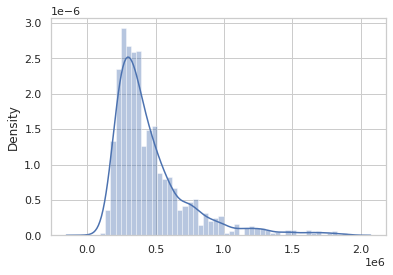

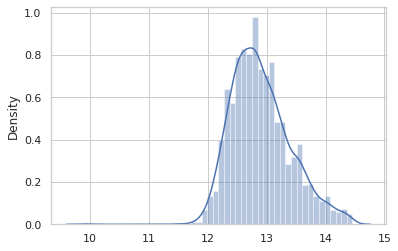

In [402]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1#

sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

#Quick Analysis of House Price Data
x = ys_train
sns.set_style('whitegrid')
sns.distplot(x)
plt.show()

x_log = np.log(x)
sns.distplot(x_log)
plt.show()

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

The following blocks build up the model definition and feed in the test data tracking the convergence (loss minimisation) of the model over 50000 iterations and ultimately calclating the MAE and MAPE 

In [403]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 2,586.4


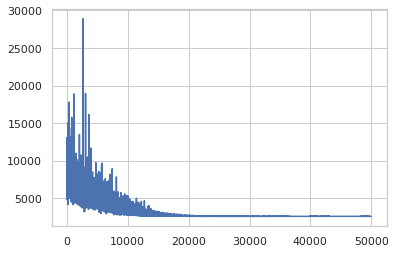

In [404]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter, method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [405]:
# samples from the posterior
posterior = approximation.sample(5000)

In [406]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  153486.13167910324
MAPE =  0.23308855785622876


Here the MAE reads 153486.13 which I think reads that the model on averae is 150K out agains the actual price of the house. This is not ideal. The MAPE tells us the average error in relation to over all data is in the order of 23.3% 

## Clustering

The clustering concept is based on the assumption that certain groups of data points can be grouped by having similar characteristics. Once we have the groups we will be able to apply the same modeling approach as above to each of the clusters to see if we can get an overall improvement of the model prediction capability.
 
The first step in the clustering process is to identify the features to base the clustering on. For this problem it stands to reason the location of property in Dublin will have a huge impact on the price and the property types within that cluster.
 
So the below block applies the Gaussian Mixture Modelling (GMM) technique to the data using the Longitude and Latitude data. It is seen to pick out 4 clear data centres with a good distribution of data across the clusters.

### Full Model

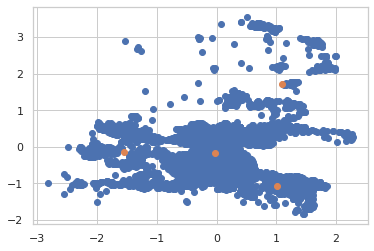

In [407]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[3,4]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

### Clusters (Definition & Data Prep)

In [408]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 375, 1: 484, 2: 1458, 3: 410}

In [409]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 79, 1: 55, 2: 236, 3: 63}

### Preparation of Data in the Clusters

The following blocks look to prep the data (as we did in the baseline model) taking the scaled features and the scaled values of the log of the output price.



In [410]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]
ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [411]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [412]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [413]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

Once the data has been prepared is its passed in to a model genrator per cluster. 

In [414]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)



Finished [100%]: Average Loss = 379.03


In [415]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 464.27


In [416]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,384.8


In [417]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 401.2


##Simulation

We can visually see that the predicited values do an ok job at tracking the observed outputs.

In [418]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred


### Simulation on Cluster 0

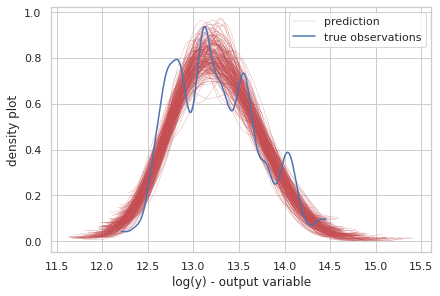

In [419]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Simulation on Cluster 1

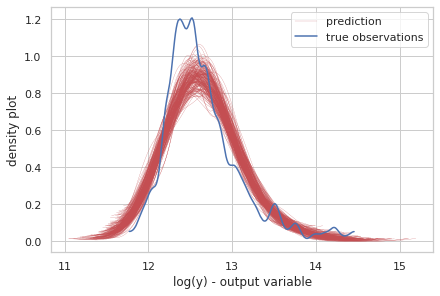

In [420]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Simulation on Cluster 2

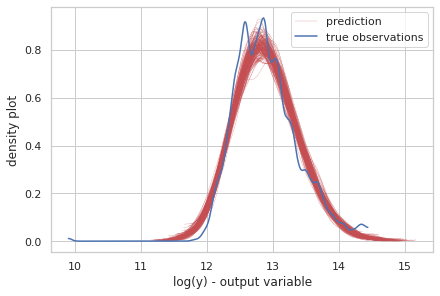

In [421]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Simulation on Cluster 3

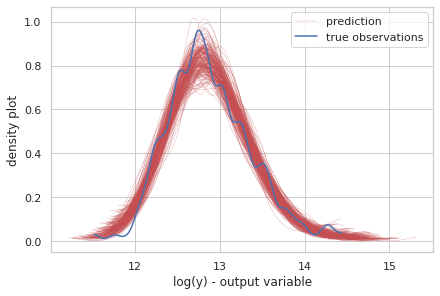

In [422]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

## Test set performance

The following block combines the output of all the clustered models and calculates the MAE and MAPE so we can compare to the baseline regression model. It can be seen that ~3% improvement in using the segmented modelling approach against the baseline standard regression model.

In [423]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# joint MAPE
joint_MAPE=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]) / y_test[clusters_test==0],
                     abs(y_pred_BLR1 - y_test[clusters_test==1]) / y_test[clusters_test==1],
                     abs(y_pred_BLR2 - y_test[clusters_test==2]) / y_test[clusters_test==2],
                     abs(y_pred_BLR3 - y_test[clusters_test==3]) / y_test[clusters_test==3]
                    ])

# MAE
print("MAE=",np.mean(joint))

# MAPE
print("MAPE=",np.mean(joint_MAPE))

Size Cluster0 79 , MAE Cluster0= 208174.54630252882
Size Cluster1 55 , MAE Cluster1= 84494.25891980705
Size Cluster2 236 , MAE Cluster2= 139019.05096121927
Size Cluster3 63 , MAE Cluster3= 126051.27085762202
MAE= 142823.78634957763
MAPE= 0.2153669607780409


### PPC on the Test set



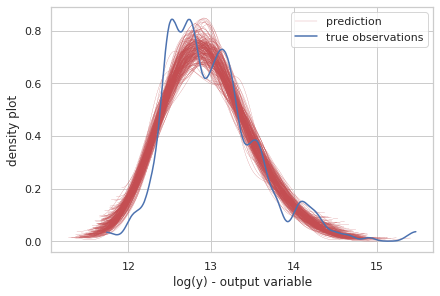

In [424]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)


# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# REFERENCES

1. Analytics Vidhya. 2021. Detecting and Treating Outliers | How to Handle Outliers. [online] Available at: <https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/> [Accessed 26 September 2021].

2. Cossairt, J., 2021. Safety for Particle Accelerators, by Thomas Otto, 2020, 148 pp. Springer Nature Switzerland AG. Gewerbestrasse 11, 6330 Cham, Switzerland; ISBN 978-3-030-57030-9 (hardcover), ISBN 978-3-030-57031-6 (pdf); https://www.springer.com/gp/book/9783030570309. Health Physics, 121(3), pp.250-250.

3. Johannemann, J., Hadad, V., Athey, S. and Wager, S., 2019. Sufficient representations for categorical variables. arXiv preprint arXiv:1908.09874.

4. “Gaussian Mixture Models: Clustering Algorithm Python.” Analytics Vidhya, 22 Apr. 2020, https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/. 


# SUMMARY

This exercise presented a data set containing information about houses in the Dublin area. The goal was to apply advanced machine learning to the dataset to attempt to predict the house price based on a set of relevant features. The  called for the application Piecewise Regression to the dataset to see if an appropriate model could be derived. The approach involved applying EDA, developing a baseline regression model for comparison, segmenting the data and applying Piecewise Regression to see if an improved result could be attained.

The data set contained training data (2982 records with 17 features including price), test data (500 records with 16 features) and test house prices (500 records). Initial EDA identified a number of fields that could be discarded immediately

Through EDA a list of features to drop was established. This was based on text based categorical values, missing values, low value features etc. Initially I had decided to drop all categorical values but based on some input from the group it stood to reason to include the BER and Type features in the analysis. I included the BER data in the model generation but for some reason including the Type seemed to throw the results off so decided to drop it as I did not have resources to investigate.

Encoding of Categorical values was done using Ordinal encoding for BER and one-hot for Type. There was some feedback in the forums around ordinally encoding the Type but I didn't see it held enough value to do that so I proceeded with one-hot.

Inputting and stipping outliers was a key component of the work. I used the z-score approach to strip outliers from the numeric features [beds, bathrooms, surface, price]. I had initially included long/lat in this but (based on input from peers saw this as too aggressive) then moved to just strip the outliers manually.

Clustering the data was a key factor in the success of the solution. I used the suggested GMM with 4 components but I would have liked to assess some options that others have put forward and we covered last year - K-Means, Elbow Analysis etc to establish the optimum clustering element to the solution.
The comparison of the baseline regression to the piecewise was the acid test of the solution.
 
The base line offered the following results:
* MAE =  153486.13167910324
* MAPE =  0.23308855785622876

With the piecewise in place I observed the following results:
* Size Cluster0 79 , MAE Cluster0= 208174.54630252882
* Size Cluster1 55 , MAE Cluster1= 84494.25891980705
* Size Cluster2 236 , MAE Cluster2= 139019.05096121927
* Size Cluster3 63 , MAE Cluster3= 126051.27085762202

Overall
* MAE= 142823.78634957763
* MAPE= 0.2153669607780409

Overall I found this a very interesting task. I wouldn’t be very happy with the model performance given the average house price in the data set is 535K and the model is out by 142K on average. I also felt the exercise really solidified the EDA and Feature Engineering theory in the context of a real life problem. 
So a conclusion can be drawn that the Piecewise is a powerful alternative to standard regression but in this particular case the improvement is not significant.  